In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Imports d'utilitats pròpies
from utils.dataset import load_dataset, create_transforms
from utils.models import ConvNet
from utils.image import assemble_biopsy_image


In [43]:
# Desactivem un warning de pytorch que podem ignorar (https://github.com/pytorch/pytorch/issues/97207) 
import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                        message='TypedStorage is deprecated')


In [44]:
# Carreguem el dataset a partir del path on es troben les imatges
base_path = "./dataset/validation"
images, labels, metadata = load_dataset(base_path)

# Tenim la mitjana i la desviació estàndard calculades de tot el dataset
mean = [0.81347498, 0.63322876, 0.73320979]
std = [0.14166194, 0.21040623, 0.15166305]

data_transforms = create_transforms(mean, std)


Carregant imatges IDC-positives...: 100%|██████████| 562/562 [00:00<00:00, 6244.47it/s]


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = "./model_entrenat.pt"

positive_threshold = 0.7

# Instanciem el model i carreguem els pesos
model = ConvNet().to(device)
model.load_state_dict(torch.load(model_path))

correct = 0
incorrect = 0
result = []

model.eval()
with torch.no_grad():
    for image, label, meta in zip(images, labels, metadata):
        temp_image = image
        image = data_transforms(image)
        image = image.unsqueeze(0)
        image = image.to(device)

        output = model(image)
        prediction = torch.sigmoid(output)
        predicted_class = prediction.item() > positive_threshold

        is_correct = label.item() == predicted_class
        if is_correct:
            correct += 1
        else:
            incorrect += 1

        # Guardem a result la imatge, la classe real, la classe predita i les metadades
        result.append((temp_image, label.item(), predicted_class, meta))


print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")


Correct: 2387
Incorrect: 385


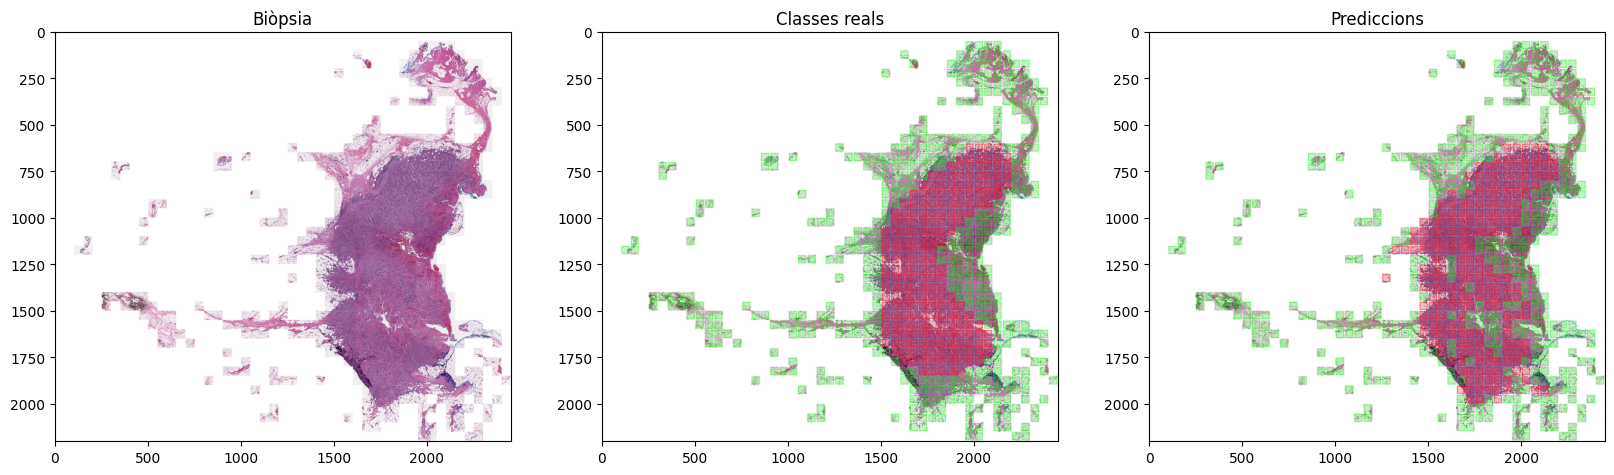

In [51]:
def get_biopsy_images(data, biopsy_id):
    biopsy_data = []
    for entry in data:
        if entry[3][0] == biopsy_id:
            biopsy_data.append(entry)

    biopsy_images = np.array([entry[0] for entry in biopsy_data])
    biopsy_metadata = np.array([entry[3] for entry in biopsy_data])
    biopsy_predictions = np.array([entry[2] for entry in biopsy_data])
    biopsy_ground_truth = np.array([entry[3][3] for entry in biopsy_data])

    return biopsy_images, biopsy_metadata, biopsy_predictions, biopsy_ground_truth


biopsy_images, biopsy_metadata, biopsy_predictions, biopsy_ground_truth = get_biopsy_images(
    result, 10257)


# Generem les imatges de les biòpsies (original, amb les prediccions i amb les classes reals)
biopsy_img = assemble_biopsy_image(biopsy_images, biopsy_metadata)
predictions_img = assemble_biopsy_image(
    biopsy_images, biopsy_metadata, biopsy_predictions)
ground_truth_img = assemble_biopsy_image(
    biopsy_images, biopsy_metadata, biopsy_ground_truth)

_, axarr = plt.subplots(1, 3, figsize=(20, 20))

axarr[0].imshow(biopsy_img)
axarr[0].set_title("Biòpsia")
axarr[1].imshow(ground_truth_img)
axarr[1].set_title("Classes reals")
axarr[2].imshow(predictions_img)
axarr[2].set_title("Prediccions")

plt.show()
